In [4]:
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode

import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read ERA as GRIB files

The [ERA5-Land monthly averaged Reanalysis-data](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview) has been manually downloaded from the copernicus climate change service.

In [13]:
# tmean and LAI 1968-2023
df1 = xr.open_dataset("files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib", filter_by_keys={'stepType': 'avgid'}).to_dataframe().reset_index().dropna().reset_index(drop=True)
# rain 1968 - 2001
df2 = xr.open_dataset("files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib", filter_by_keys={'stepType': 'avgas'}).to_dataframe().reset_index().dropna().reset_index(drop=True)
# rain 2002-2023
df3 = xr.open_dataset("files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib", filter_by_keys={'stepType': 'avgad'}).to_dataframe().reset_index().dropna().reset_index(drop=True)

rain = pd.concat([df2, df3], ignore_index=True).dropna().reset_index(drop=True)
era = df1.merge(rain, on=["time", "latitude", "longitude", "number", "step", "surface", "valid_time"])

Ignoring index file 'files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib.923a8.idx' incompatible with GRIB file
Ignoring index file 'files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib.923a8.idx' incompatible with GRIB file
Ignoring index file 'files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib.923a8.idx' incompatible with GRIB file


### 2. Preprocess ERA

In [14]:
# Kelvin to Celsius
era["t2m"] = era["t2m"].apply(lambda x: x - 273.15)
# Precipitation from m to mm
era["tp"] = era["tp"].apply(lambda x: x * 1000)
# time to datetime
era["time"] = pd.to_datetime(era["time"])
era["valid_time"] = pd.to_datetime(era["valid_time"])

era = (era
       .sort_values(by=["time", "latitude", "longitude"])
       .loc[:, ["time", "latitude", "longitude", "t2m", "tp"]]
       .rename(columns={"latitude":"lat", "longitude":"lon", "t2m":"tmean", "tp":"rain"})
       .reset_index(drop=True))

era["month"] = era["time"].dt.month
era["year"] = era["time"].dt.year
era = era.loc[era["month"].between(8,11) & (era["year"].between(1993,2016))].reset_index(drop=True)
era = era[["time", "lat", "lon", "rain", "tmean", "month", "year"]]
era = gpd.GeoDataFrame(era, geometry=gpd.points_from_xy(era["lon"], era["lat"], crs="EPSG:4326"))

era.head(2)

,time,lat,lon,rain,tmean,month,year,geometry
0,1993-08-01,-42.0,-69.0,0.708799,0.844141,8,1993,POINT (-69.00000 -42.00000)
1,1993-08-01,-42.0,-68.9,0.660802,0.514063,8,1993,POINT (-68.90000 -42.00000)


### 3. Filter ERA by study regions

In [15]:
# Read polygons of agro-climatic regions
regions_shape = gpd.read_file("files/shapefiles/study_region_v2.shp")

# Filter by agro-climatic regions
era = gpd.GeoDataFrame(era, geometry=gpd.points_from_xy(era["lon"], era["lat"], crs="EPSG:4326"))
coordinates = gpd.sjoin(era[["geometry", "lat", "lon"]].drop_duplicates(), regions_shape[["region", "geometry"]]).reset_index(drop=True)[["region", "lat", "lon", "geometry"]]
era = era.merge(coordinates[["lat", "lon", "region"]], on=["lat", "lon"], how="right")

era.head()

,time,lat,lon,rain,tmean,month,year,geometry,region
0,1993-08-01,-40.9,-62.8,0.220845,10.486719,8,1993,POINT (-62.80000 -40.90000),Llanos nordpatagónicos
1,1993-09-01,-40.9,-62.8,0.795223,10.734521,9,1993,POINT (-62.80000 -40.90000),Llanos nordpatagónicos
2,1993-10-01,-40.9,-62.8,0.898267,14.625391,10,1993,POINT (-62.80000 -40.90000),Llanos nordpatagónicos
3,1993-11-01,-40.9,-62.8,1.885483,16.910059,11,1993,POINT (-62.80000 -40.90000),Llanos nordpatagónicos
4,1994-08-01,-40.9,-62.8,0.795424,9.287012,8,1994,POINT (-62.80000 -40.90000),Llanos nordpatagónicos


#### 4. Plot climate conditions

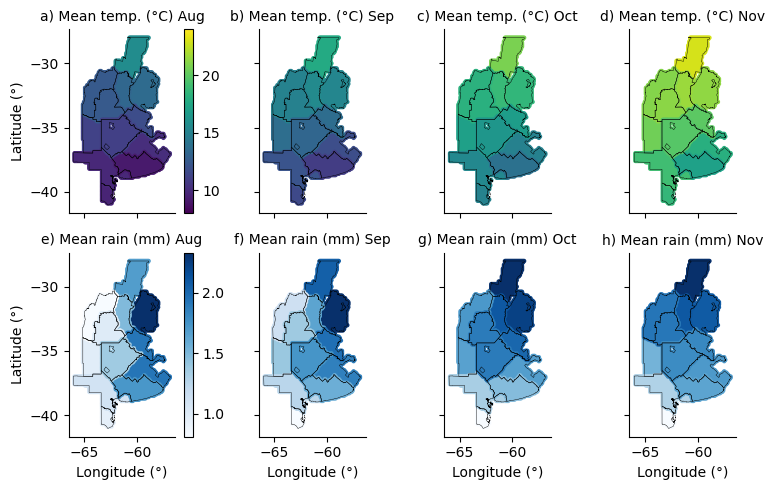

In [16]:
fig, axs = plt.subplots(2, 4, figsize=(8, 5), sharex=True, sharey=True)
#axs = axs.ravel()

months_titles = ["Aug", "Sep", "Oct", "Nov"]
list_of_counter = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)"]

for counter in list(range(0, 4)):
    show_legend = True
    if counter > 0:
        show_legend = False
    era_plot = era.loc[era["month"] == (8 + counter)].dissolve(
                by=["region"],
                aggfunc={
                    "rain": "mean",
                    "tmean": "mean",
                }
            ).reset_index()
    era_plot.plot(ax=axs[0][counter], column="tmean", linewidth=2, markersize=1.5, legend=show_legend, vmin=8, vmax=24)
    regions_shape.plot(ax=axs[0][counter], color="none", edgecolor="black", linewidth=.3)
    axs[0][counter].set_title("{} Mean temp. (°C) {}".format(list_of_counter[counter], months_titles[counter]), fontsize=10)
    axs[0][counter].set_yticks([-40, -35, -30])
    if counter == 0:
        axs[0][counter].set_ylabel("Latitude (°)")
    
    
    era_plot.plot(ax=axs[1][counter],column="rain", linewidth=2, markersize=1.5, legend=show_legend, cmap="Blues")
    regions_shape.plot(ax=axs[1][counter], color="none", edgecolor="black", linewidth=.3)
    axs[1][counter].set_title("{} Mean rain (mm) {}".format(list_of_counter[counter+4], months_titles[counter]), fontsize=10)
    axs[1][counter].set_yticks([-40, -35, -30])
    if counter == 0:
        axs[1][counter].set_ylabel("Latitude (°)")
    axs[1][counter].set_xlabel("Longitude (°)")

plt.tight_layout()
plt.show()
    

### 5. Preprocess dataset

#### 5.1 Regional mean

In [17]:
era_grouped = era.groupby(["region", "year", "month"])[["rain", "tmean"]].mean().reset_index()
era_grouped.head(2)

,region,year,month,rain,tmean
0,Chaco húmedo sur,1993,8,0.493928,14.790287
1,Chaco húmedo sur,1993,9,2.176070,16.293998


#### 5.2 Restructure dataset

In [18]:
era_features = era_grouped.pivot(index=["region", "year"], columns=["month"], values=["rain", "tmean"])
era_features.columns = ["{}_{}".format(s[0],s[1]) for s in era_features.columns]
era_features = era_features.reset_index()
era_features.head()

,region,year,rain_8,rain_9,rain_10,rain_11,tmean_8,tmean_9,tmean_10,tmean_11
0,Chaco húmedo sur,1993,0.493928,2.176070,9.256403,7.423758,14.790287,16.293998,20.237399,21.583416
1,Chaco húmedo sur,1994,3.593458,2.981551,6.135265,4.459834,14.627999,18.966375,20.038065,22.095344
2,Chaco húmedo sur,1995,0.667157,2.482436,3.225337,2.586036,15.433782,18.199902,19.412001,24.701423
3,Chaco húmedo sur,1996,1.240848,2.794151,4.560018,6.592334,18.377543,17.072297,20.541602,23.234678
4,Chaco húmedo sur,1997,1.920096,1.232661,5.843807,5.093093,16.993994,19.120365,20.611670,22.914275


# EXPORT

In [19]:
era_features.to_csv("files/ERA/processed/era_regions_features_8_11.csv", index=False)